Setup and Loading

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import date
import re

In [ ]:
df_churn  = pd.read_csv('raw_data/train/churn_labels.csv')
df_claims = pd.read_csv('raw_data/train/claims.csv')
df_web    = pd.read_csv('raw_data/train/web_visits.csv')
df_app    = pd.read_csv('raw_data/train/app_usage.csv')

print(f"Churn Labels (Members): {df_churn.shape}")
print(f"Claims: {df_claims.shape}")
print(f"Web Visits: {df_web.shape}")
print(f"App Usage: {df_app.shape}")

Schema Exploration

In [10]:
def schema_report(df, name):
    print(f"\n=== {name} ===")
    display(df.dtypes.to_frame("dtype"))
    display(df.isna().mean().sort_values(ascending=False).to_frame("missing_rate").head(20))
    display(df.nunique().sort_values(ascending=False).to_frame("nunique").head(20))

schema_report(df_churn, "labels")
schema_report(df_claims, "claims")
schema_report(df_web, "web")
schema_report(df_app, "app")


=== labels ===


,dtype
member_id,int64
signup_date,str
churn,int64
outreach,int64


,missing_rate
member_id,0.0
signup_date,0.0
churn,0.0
outreach,0.0


,nunique
member_id,10000
signup_date,517
churn,2
outreach,2



=== claims ===


,dtype
member_id,int64
icd_code,str
diagnosis_date,str


,missing_rate
member_id,0.0
icd_code,0.0
diagnosis_date,0.0


,nunique
member_id,9980
diagnosis_date,14
icd_code,10



=== web ===


,dtype
member_id,int64
url,str
title,str
description,str
timestamp,str
url_category,str


,missing_rate
member_id,0.0
url,0.0
title,0.0
description,0.0
timestamp,0.0
url_category,0.0


,nunique
timestamp,233607
url,69894
member_id,9975
title,26
description,26
url_category,23



=== app ===


,dtype
member_id,int64
event_type,str
timestamp,str


,missing_rate
member_id,0.0
event_type,0.0
timestamp,0.0


,nunique
timestamp,93900
member_id,9998
event_type,1


Validate Observation Window

In [13]:
df_web["timestamp"] = pd.to_datetime(df_web["timestamp"], errors="coerce")
df_app["timestamp"] = pd.to_datetime(df_app["timestamp"], errors="coerce")
df_claims["diagnosis_date"] = pd.to_datetime(df_claims["diagnosis_date"], errors="coerce")
df_churn["signup_date"] = pd.to_datetime(df_churn["signup_date"], errors="coerce")

OBS_START = pd.to_datetime("2025-07-01").date()
OBS_END   = pd.to_datetime("2025-07-14").date()

def summarize(name, series):
    s = series.dropna()
    print(f"{name}: min={s.min()}, max={s.max()}")
    print(f"  outside window: {(s < OBS_START).sum()} before, {(s > OBS_END).sum()} after")

print("Observation window:", OBS_START, "to", OBS_END)

summarize("web", df_web["timestamp"].dt.date)
summarize("app", df_app["timestamp"].dt.date)
summarize("claims", df_claims["diagnosis_date"].dt.date)

Observation window: 2025-07-01 to 2025-07-14
web: min=2025-07-01, max=2025-07-14
  outside window: 0 before, 0 after
app: min=2025-07-01, max=2025-07-14
  outside window: 0 before, 0 after
claims: min=2025-07-01, max=2025-07-14
  outside window: 0 before, 0 after


Check Churn Rate

In [14]:
print("Churn rate:", df_churn["churn"].mean())
print("Outreach rate:", df_churn["outreach"].mean())

display(df_churn["churn"].value_counts(normalize=True))
display(df_churn["outreach"].value_counts(normalize=True))

display(
    df_churn.groupby("outreach")["churn"]
    .mean()
    .to_frame("churn_rate_by_outreach")
)

Churn rate: 0.2021
Outreach rate: 0.3984


churn
0    0.7979
1    0.2021
Name: proportion, dtype: float64

outreach
0    0.6016
1    0.3984
Name: proportion, dtype: float64

,churn_rate_by_outreach
outreach,
0,0.207447
1,0.194026


Web Analysis

In [24]:

df = df_web.copy()

df["url_clean"] = (
    df["url"].fillna("")
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9\s/._-]", " ", regex=True)
)

df["text_clean"] = (
    (df["title"].fillna("") + " " + df["description"].fillna(""))
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z\s]", " ", regex=True)
)

# --- 2) Define the WellCo engagement fields (from the brief) ---
FIELD_KEYWORDS = {
    "Movement_PhysicalActivity": [
        "movement", "physical activity", "exercise", "aerobic", "strength training",
        "strength", "cardio", "cardiovascular", "fitness", "workout", "endurance"
    ],
    "Sleep_Health": [
        "sleep", "sleep hygiene", "restorative sleep", "sleep quality",
        "apnea", "sleep apnea", "insomnia"
    ],
    "Resilience_Wellbeing": [
        "resilience", "wellbeing", "wellness", "stress", "stress management",
        "mindfulness", "meditation", "mental health", "anxiety"
    ],
}

# --- 3) Helper: count keyword occurrences (handles multi-word phrases) ---
def count_occurrences(series: pd.Series, phrases: list[str]) -> pd.Series:
    patterns = []
    for p in phrases:
        p = p.strip().lower()
        # word-boundaries for single words; flexible whitespace for phrases
        if " " in p:
            pat = r"\b" + r"\s+".join(map(re.escape, p.split())) + r"\b"
        else:
            pat = r"\b" + re.escape(p) + r"\b"
        patterns.append(pat)
    combined = "(" + "|".join(patterns) + ")"
    return series.str.count(combined, flags=re.IGNORECASE)

# --- 4) Create per-row counts for URL and Text ---
for field, phrases in FIELD_KEYWORDS.items():
    df[f"{field}_url_count"] = count_occurrences(df["url_clean"], phrases)
    df[f"{field}_text_count"] = count_occurrences(df["text_clean"], phrases)
    df[f"{field}_total_count"] = df[f"{field}_url_count"] + df[f"{field}_text_count"]

# --- 5) Optional: aggregate to member-level features ---
field_cols = []
for field in FIELD_KEYWORDS.keys():
    field_cols += [f"{field}_url_count", f"{field}_text_count", f"{field}_total_count"]

member_features = (
    df.groupby("member_id")[field_cols]
      .sum()
      .reset_index()
)

member_features.head()

,member_id,Movement_PhysicalActivity_url_count,Movement_PhysicalActivity_text_count,Movement_PhysicalActivity_total_count,Sleep_Health_url_count,Sleep_Health_text_count,Sleep_Health_total_count,Resilience_Wellbeing_url_count,Resilience_Wellbeing_text_count,Resilience_Wellbeing_total_count
0,1,0,0,0,0,0,0,0,0,0
1,2,2,6,8,1,3,4,4,3,7
2,3,6,16,22,4,11,15,13,10,23
3,4,1,2,3,2,5,7,4,7,11
4,5,2,4,6,2,5,7,2,1,3


In [17]:
df_web["url_category"] = df_web["url"].apply(
    lambda x: str(x).split("/")[-2]
    if str(x).split("/")[-1].isdigit()
    else "uncategorized"
)

display(df_web["url_category"].value_counts().head(20))

url_category
travel          22600
tech            22553
cars            22395
movies          22271
sports          22257
gaming          21337
pets            14636
nutrition       11473
sleep           11369
heart           11295
finance          9791
recipes          5789
aerobic          5687
fitness          5648
hypertension     5640
stress           5620
chronic          5613
mindfulness      5597
wellness         5595
strength         5570
Name: count, dtype: int64

App Sessions Analysis

count    9998.000000
mean        9.780856
std         3.625525
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        26.000000
dtype: float64

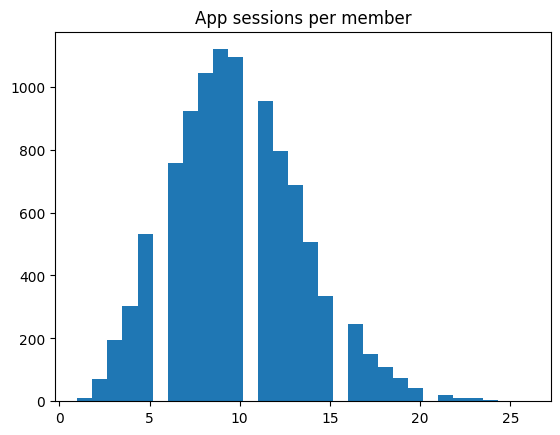

In [19]:
app_sessions = df_app.groupby("member_id").size()

display(app_sessions.describe())

plt.hist(app_sessions, bins=30)
plt.title("App sessions per member")
plt.show()

Claims Analysis

In [20]:
claims_key = ["member_id","icd_code","diagnosis_date"]

dup_count = df_claims.duplicated(subset=claims_key).sum()
print("Duplicates:", dup_count)

display(
    df_claims[df_claims.duplicated(subset=claims_key, keep=False)]
    .sort_values(claims_key)
    .head(20)
)

Duplicates: 1676


,member_id,icd_code,diagnosis_date
23,4,I10,2025-07-11
25,4,I10,2025-07-11
48,9,H10.9,2025-07-03
49,9,H10.9,2025-07-03
62,11,Z71.3,2025-07-11
67,11,Z71.3,2025-07-11
69,11,Z71.3,2025-07-11
112,17,H10.9,2025-07-05
116,17,H10.9,2025-07-05
117,18,Z71.3,2025-07-01
